In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
figsize(10, 8)

In [6]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [7]:
rc = 335.7133441444117
dc = 63.43802542905474

In [8]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [9]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=0, removeplane=True):
    #dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * (~innerregion.flatten()) * (~outerregion.flatten())
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        signal = gaussian_filter(signal, smth/pixbeam)
        shits = gaussian_filter(hits, smth/pixbeam)
        mask = shits < 1
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('LON [degrees]')
        ylabel('LAT [degrees]')
        cb.set_label('Flux [Jy/pixel]')
        title('Bank '+bank)

    print np.nansum(signal[innerregion])
    return rabinsc, decbinsc, signal

33.83784991


/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


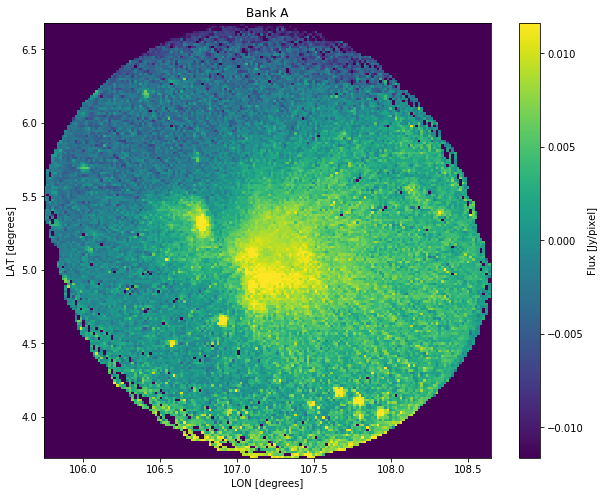

In [10]:
lons, lats, signal = calculate_sflux_gal(smth=0)

In [17]:
gridx, gridy = np.meshgrid(lons, lats)

In [44]:
len(lons)

173

In [45]:
len(lats)

176

In [47]:
signal.shape

(176, 173)

In [48]:
len(gridx)

176

In [54]:
len(gridy)

176

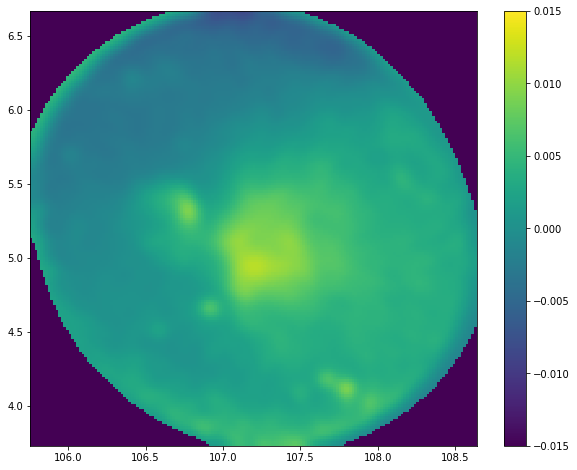

In [18]:
pcolormesh(lons, lats, signal)
clim(-0.015, 0.015)
cm = colorbar();
#contour(gridx, gridy, signal, cmap=cm.cmap)

In [78]:
z = np.load('../externaldata/dustdata_gridded.npz')

In [79]:
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']
dlons = 0.5 * (dlons[1:] + dlons[:-1])
dlats = 0.5 * (dlats[1:] + dlats[:-1])

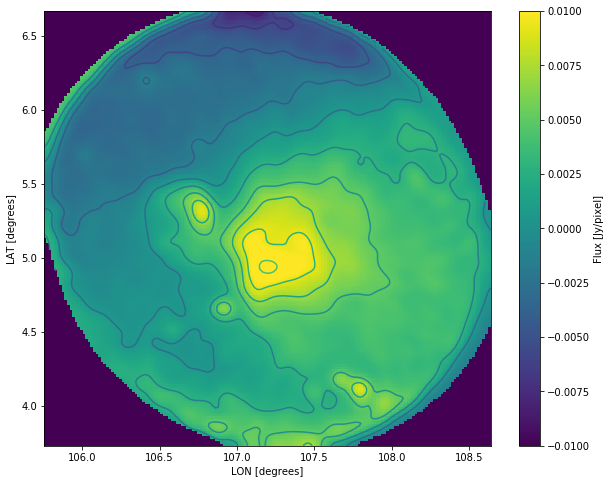

In [80]:
pcolormesh(lons, lats, signal)
clim(-0.01, 0.01)
cm = colorbar();
contour(gridx, gridy, signal, levels=np.linspace(-0.01, 0.02, 15))
xlabel('LON [degrees]')
ylabel('LAT [degrees]')
cm.set_label('Flux [Jy/pixel]')

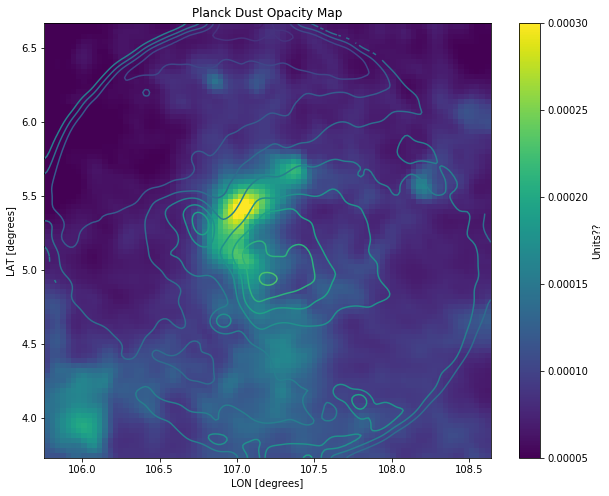

In [95]:
pcolormesh(dlons, dlats, dsig)
clim(0.00005, 0.0003)
cm = colorbar();
contour(gridx, gridy, signal, levels=np.linspace(-0.01, 0.02, 15))
xlabel('LON [degrees]')
ylabel('LAT [degrees]')
title('Planck Dust Opacity Map')
cm.set_label('Units??')
savefig('figures/dust_opacity_gbt_contours')

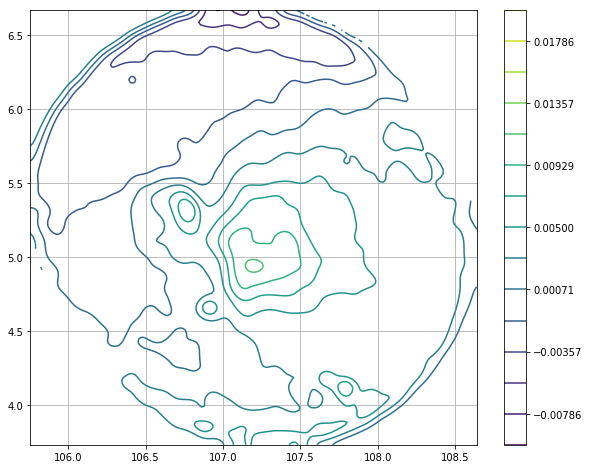

In [82]:
contour(gridx, gridy, signal, levels=np.linspace(-0.01, 0.02, 15))
grid()
colorbar()

In [83]:
dgridx, dgridy = np.meshgrid(dlons, dlats)

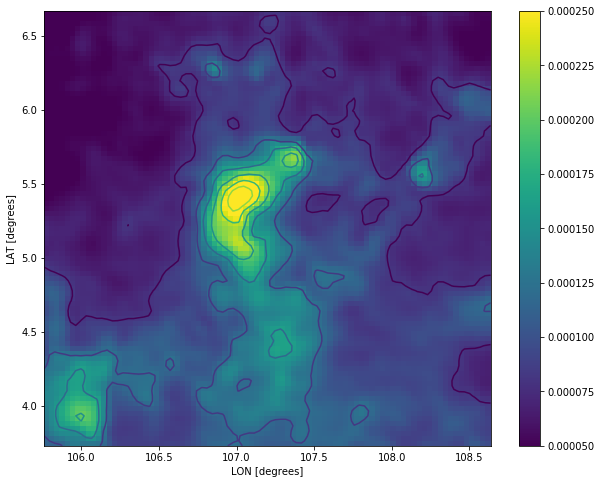

In [84]:
pcolormesh(dlons, dlats, dsig)
clim(0.00005, 0.00025)
cm = colorbar();
contour(dgridx, dgridy, dsig)
xlabel('LON [degrees]')
ylabel('LAT [degrees]')
#cm.set_label('Flux [Jy/pixel]')

In [85]:
dgridx, dgridy = np.meshgrid(dlats, dlons)

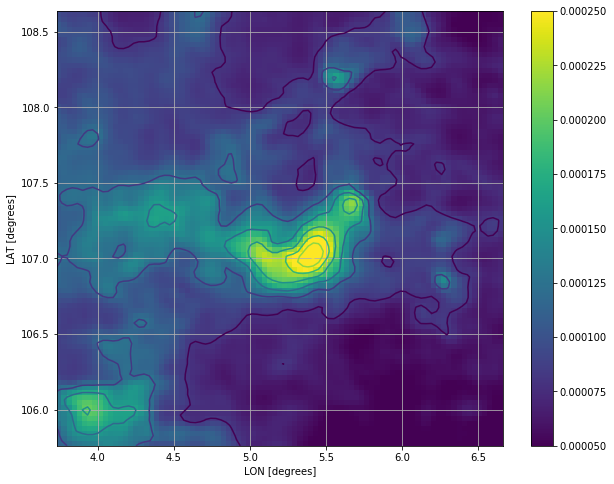

In [92]:
pcolormesh(dlats, dlons, dsig.T)
clim(0.00005, 0.00025)
cm = colorbar();
contour(dgridx, dgridy, dsig.T)
xlabel('LON [degrees]')
ylabel('LAT [degrees]')
grid()
#cm.set_label('Flux [Jy/pixel]')

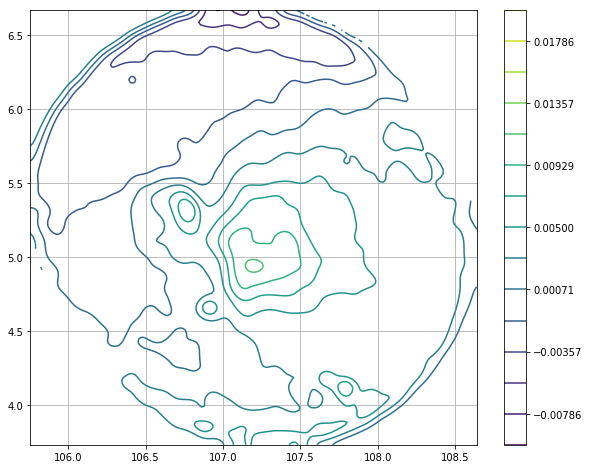

In [82]:
contour(gridx, gridy, signal, levels=np.linspace(-0.01, 0.02, 15))
grid()
colorbar()